<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/PANAS_SF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#FONT SIZE

In [ ]:
def increase_font():
  from IPython.display import Javascript
  display(Javascript('''
  for (rule of document.styleSheets[0].cssRules){
    if (rule.selectorText=='body') {
      rule.style.fontSize = '24px'
      break
    }
  }
  '''))
get_ipython().events.register('pre_run_cell', increase_font)

# PANAS

In [ ]:
import pytz
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from wordcloud import WordCloud
import os
from scipy.stats import ttest_ind, ttest_rel, ttest_ind_from_stats, ttest_1samp
from sklearn.linear_model import LinearRegression

from google.colab import drive
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

auth.authenticate_user()

from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

<IPython.core.display.Javascript object>

In [ ]:
fn = 'I-PANAS-SF (Responses)'
worksheet = gc.open(fn).sheet1
rows = worksheet.get_all_values()
df = pd.DataFrame.from_records(rows)
df.columns = df.loc[0].str.rstrip()
df = df.drop(0).reset_index(drop=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Timestamp'] = df['Timestamp'].dt.tz_localize(tz=pytz.timezone('US/Eastern'))
df['Are you employed'] = df['Are you employed'].replace(['Yes','No', 'Yes, No'],[1,0,0])
int_cols = ['PANAS [Upset]', 'PANAS [Hostile]', 'PANAS [Alert]',
       'PANAS [Ashamed]', 'PANAS [Inspired]', 'PANAS [Nervous]',
       'PANAS [Determined]', 'PANAS [Attentive]', 'PANAS [Afraid]',
       'PANAS [Active]', 'How much water have you drank today?',
       'How much have you had to eat today?', 'Are you employed',
       'Did you have a good day at work', 'Age']
df.loc[:,int_cols] = df.loc[:,int_cols].astype(float).round(0).astype(int)
codename_cols = [x[27:-1] for x in df.columns.values if 'Give yourself a codename' in x]
df = df.rename(columns={k:v for k,v in zip([x for x in df.columns.values if 'Give yourself a codename' in x], codename_cols)})
df.shape

<IPython.core.display.Javascript object>

(686, 26)

In [ ]:
panas_pa = ['Determined', 'Attentive', 'Alert', 'Inspired', 'Active']
panas_na = ['Afraid', 'Nervous', 'Upset', 'Ashamed', 'Hostile']
panas_items = [x for x in df.columns.values if x.startswith('PANAS')]

_panas_pa = []
_panas_na = []
for x,y,z in itertools.product(panas_items,panas_pa,panas_na):
  if y in x:
    _panas_pa.append(x)
  elif z in x:
    _panas_na.append(x)

_panas_pa = list(set(_panas_pa))
_panas_na = list(set(_panas_na))


panas_scoring_standards = pd.DataFrame([df.loc[:,_panas_pa].sum(axis=1).mean(),
              df.loc[:,_panas_pa].sum(axis=1).std(),
              df.loc[:,_panas_na].sum(axis=1).mean(),
              df.loc[:,_panas_na].sum(axis=1).std()],
             index=['PA_M','PA_SD','NA_M','NA_SD']).T

_panas_scoring_standards = panas_scoring_standards.mean().to_frame().T
panas_scoring_standards = pd.DataFrame()

panas_scoring_standards = panas_scoring_standards.append(pd.DataFrame([['High Positive Affect',_panas_scoring_standards['PA_M'].add(_panas_scoring_standards['PA_SD']).values[0]]], columns=['label', 'threshold']),ignore_index=True)
panas_scoring_standards = panas_scoring_standards.append(pd.DataFrame([['Low Positive Affect',_panas_scoring_standards['PA_M'].sub(_panas_scoring_standards['PA_SD']).values[0]]], columns=['label', 'threshold']),ignore_index=True)
panas_scoring_standards = panas_scoring_standards.append(pd.DataFrame([['High Negative Affect',_panas_scoring_standards['NA_M'].add(_panas_scoring_standards['NA_SD']).values[0]]], columns=['label', 'threshold']),ignore_index=True)
panas_scoring_standards = panas_scoring_standards.append(pd.DataFrame([['Low Negative Affect',_panas_scoring_standards['NA_M'].sub(_panas_scoring_standards['NA_SD']).values[0]]], columns=['label', 'threshold']),ignore_index=True)
affect_adjustment = _panas_scoring_standards['PA_M'].sub(_panas_scoring_standards['NA_M']).values[0]

df['PA'] = df.loc[:,_panas_pa].sum(axis=1)
df['NA'] = df.loc[:,_panas_na].sum(axis=1)
df['affect'] = df['PA'].sub(df['NA']).sub(affect_adjustment)
affect_sd = df['affect'].std()
hi_aff = affect_sd
lo_aff = -affect_sd

time_now = datetime.datetime.now(tz=pytz.timezone('US/Eastern'))
time_an_hour_ago = time_now-datetime.timedelta(hours=100)

<IPython.core.display.Javascript object>

In [ ]:
data = df.loc[df['Timestamp']>=pd.to_datetime(time_an_hour_ago)]
# data = df.sample(15)

data.shape

<IPython.core.display.Javascript object>

(10, 29)

In [ ]:
panas_scoring_standards

<IPython.core.display.Javascript object>

,label,threshold
0,High Positive Affect,19.916400
1,Low Positive Affect,12.147740
2,High Negative Affect,14.205837
3,Low Negative Affect,5.890373


<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


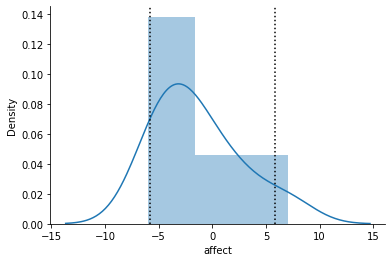

In [ ]:
sns.distplot(data['affect'])
plt.axvline(hi_aff, c='k',ls=':')
plt.axvline(lo_aff, c='k',ls=':')
sns.despine()
plt.show()

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


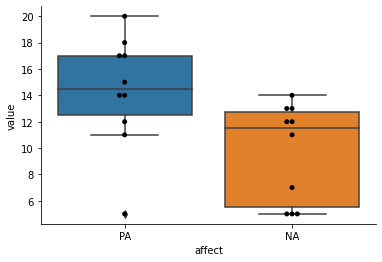

In [ ]:
sns.boxplot('affect','value',data=pd.melt(data.loc[:,['PA','NA']],var_name='affect'))
sns.swarmplot('affect','value',data=pd.melt(data.loc[:,['PA','NA']],var_name='affect'),color='k')
sns.despine()

In [ ]:
generalization = {}
for col in ['How much water have you drank today?', 'How much have you had to eat today?', 'Did you have a good day at work', 'Age']:
  model = LinearRegression()
  model.fit(df.loc[:,[col]], df.loc[:,'affect'])
  df_gen = pd.DataFrame([[x, (model.coef_[0] * x) + model.intercept_] for x in range(-100,100)])
  generalization[col] = df_gen.copy()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

How much water have you drank today?



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


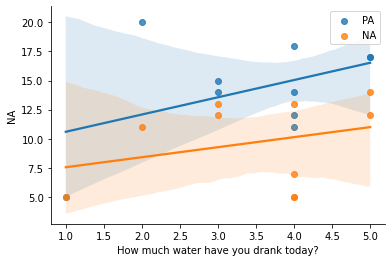

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


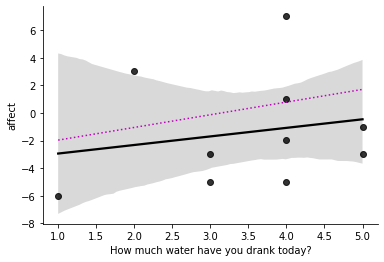

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


How much have you had to eat today?



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


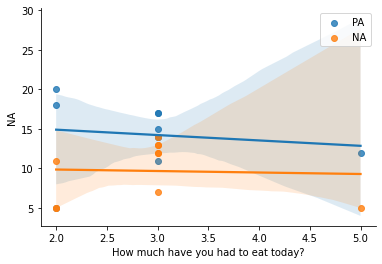

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


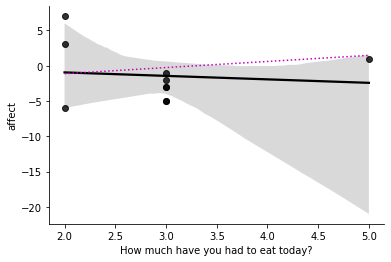

Did you have a good day at work



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


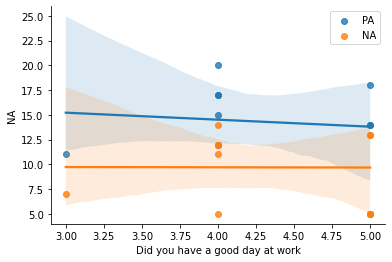

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


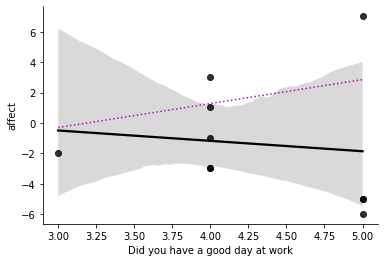

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Age



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


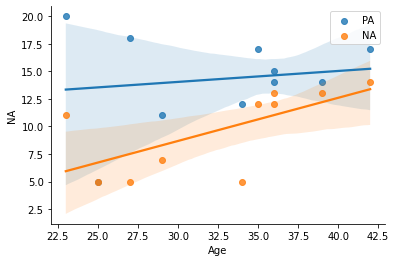

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


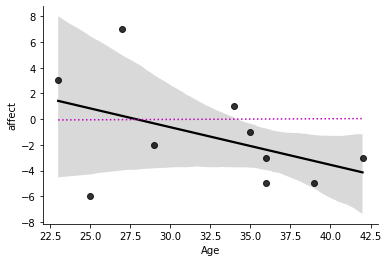

In [ ]:
for x in ['How much water have you drank today?', 'How much have you had to eat today?', 'Did you have a good day at work', 'Age']:
  print(f"{x}\n")
  sns.regplot(x,'PA',data=data,label='PA')
  sns.regplot(x,'NA',data=data,label='NA')
  plt.legend()
  sns.despine()
  plt.show()

  f = sns.regplot(x,'affect',data=data,label='affect',color='k')
  xlims = f.get_xlim()
  _gen = generalization[x]
  _gen = _gen.loc[_gen[0].between(xlims[0], xlims[1])]
  plt.plot(_gen[0], _gen[1], 'm:')
  f.set_xlim(xlims)
  sns.despine()
  plt.show()

In [ ]:
# extremes
pd.options.display.max_columns = None
data.loc[(data.loc[:,codename_cols].sum(axis=1) != '')&((data.loc[:,_panas_pa].ge(5).sum(axis=1).astype(bool))| ((data.loc[:,_panas_na].ge(5).sum(axis=1).astype(bool))))].rename(columns={x:x[6:] for x in data.columns.values if 'PANAS' in x})

<IPython.core.display.Javascript object>

,Timestamp,[Upset],[Hostile],[Alert],[Ashamed],[Inspired],[Nervous],[Determined],[Attentive],[Afraid],[Active],How much water have you drank today?,How much have you had to eat today?,Are you employed,Did you have a good day at work,Age,raccoon,bull,hedgehog,parrot,kitten,panda,bunny,lizard,owl,woodchuck,PA,NA,affect
676,2022-09-06 22:48:29-04:00,2,1,2,3,4,5,5,2,3,4,5,3,0,4,42,,,,,,,,,hypnotic,,17,14,-2.983965
679,2022-09-06 23:39:04-04:00,1,1,3,1,3,1,4,3,1,5,4,2,1,5,27,,cruel,,,,,,,,hypnotic,18,5,7.016035
681,2022-09-06 23:43:23-04:00,5,1,5,2,1,3,1,4,2,3,3,3,1,5,36,sassy,cruel,ambiguous,,sweet,sassy,,,hypnotic,,14,13,-4.983965
684,2022-09-06 23:45:53-04:00,2,1,3,2,4,5,4,2,2,4,5,3,0,4,35,,,,,,,,,cruel,,17,12,-0.983965
685,2022-09-06 23:47:28-04:00,2,1,3,2,4,4,4,5,2,4,2,2,1,4,23,,sweet,,,,sweet,,,,,20,11,3.016035


In [ ]:
data.loc[(data['bunny'] != '')]
# data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Timestamp,PANAS [Upset],PANAS [Hostile],PANAS [Alert],PANAS [Ashamed],PANAS [Inspired],PANAS [Nervous],PANAS [Determined],PANAS [Attentive],PANAS [Afraid],PANAS [Active],How much water have you drank today?,How much have you had to eat today?,Are you employed,Did you have a good day at work,Age,raccoon,bull,hedgehog,parrot,kitten,panda,bunny,lizard,owl,woodchuck,PA,NA,affect
650,2022-04-14 22:35:09-04:00,3,2,2,1,4,2,5,2,2,3,5,4,1,4,29,,,,,,hypnotic,sassy,,,,16,10,-0.06298


In [ ]:
from datetime import datetime, timedelta

In [ ]:
format(datetime.today() - timedelta(days=56), '%Y-%m-%d')

'2021-04-09'